In [1]:
subj = 'SUB'

In [1]:
# Parameters
subj = "ACR_30"


In [2]:
def get_onset_offset_aligned_data(traces, size=10, kind='max', fs=400):
    peak_aligned = {}
    indices = {}
    trial_aligned = {}
    for probe in traces.keys():
        peak_aligned[probe] = {}
        indices[probe] = {}
        trial_aligned[probe] = {}
        for condition in traces[probe].keys():
            ra = traces[probe][condition].mean(axis=2)
            pks = acr.sync.compute_slope_df(traces[probe][condition], fs=fs, find=kind)
            peak_aligned[probe][condition] = []
            indices[probe][condition] = []
            trial_aligned[probe][condition] = []
            for chan in np.arange(1, 17):
                middle = ra.shape[1]/2
                peak_index = pks.iloc[chan-1]['extrema']
                indices[probe][condition].append(pks.iloc[chan-1]['extrema_rel_position'])
                peak_index_raw = peak_index #+ middle
                start = int(peak_index_raw-size)
                stop = int(peak_index_raw+size)+1
                chan_peak_data = ra[chan-1, start:stop]
                trial_aligned_data = traces[probe][condition][chan-1, start:stop, :]
                if chan_peak_data.shape[0] < size*2:
                    chan_peak_data = np.ones(size*2)+1
                peak_aligned[probe][condition].append(chan_peak_data)
                trial_aligned[probe][condition].append(trial_aligned_data)
            peak_aligned[probe][condition] = np.array(peak_aligned[probe][condition])
            trial_aligned[probe][condition] = np.array(trial_aligned[probe][condition])
    return indices, peak_aligned, trial_aligned

In [3]:
def get_peak_aligned_data(traces, size=30):
    peak_aligned = {}
    indices = {}
    trial_aligned = {}
    for probe in traces.keys():
        peak_aligned[probe] = {}
        indices[probe] = {}
        trial_aligned[probe] = {}
        for condition in traces[probe].keys():
            ra = traces[probe][condition].mean(axis=2)
            pks = acr.sync.compute_peak_df(traces[probe][condition])
            peak_aligned[probe][condition] = []
            indices[probe][condition] = []
            trial_aligned[probe][condition] = []
            for chan in np.arange(1, 17):
                middle = ra.shape[1]/2
                peak_index = pks.iloc[chan-1]['peak_position']
                indices[probe][condition].append(peak_index)
                peak_index_raw = middle + peak_index
                start = int(peak_index_raw-size)
                stop = int(peak_index_raw+size)+1
                chan_peak_data = ra[chan-1, start:stop]
                trial_aligned_data = traces[probe][condition][chan-1, start:stop, :]
                if chan_peak_data.shape[0] < (size*2)+1:
                    chan_peak_data = np.ones((size*2)+1)
                    trial_aligned_data = np.ones(((size*2)+1, traces[probe][condition].shape[2]))
                print(chan_peak_data.shape)
                peak_aligned[probe][condition].append(chan_peak_data)
                trial_aligned[probe][condition].append(trial_aligned_data)
            peak_aligned[probe][condition] = np.array(peak_aligned[probe][condition])
            trial_aligned[probe][condition] = np.array(trial_aligned[probe][condition])
    return indices, peak_aligned, trial_aligned

In [4]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import kdephys as kde
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import acr
import xarray as xr
from scipy import stats
# ---------------------------- EXTRAS --------------------------------#
from kdephys.plot.main import _title, bp_plot
import kdephys.utils.spectral as sp
bands = sp.bands
from scipy.stats import normaltest
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
from acr.utils import *
pu = acr.utils.import_publication_functions('/home/kdriessen/gh_master/PUBLICATION__ACR/pub_utils.py', 'pu')
dag = acr.utils.import_publication_functions('/home/kdriessen/gh_master/PUBLICATION__ACR/data_agg.py', 'dag')
import pingouin as pg
from scipy.stats import shapiro

In [5]:
notebook_figure_root = f'{pu.PAPER_FIGURE_ROOT}/synchrony/field_potentials/schematics'
FSZ = (3, 4)
lw=7

In [ ]:
# Loads Hypnograms
full_hyps = {}
hyp_dicts = {}
for subject in [subj]:
    full_hyps[subject] = acr.io.load_hypno_full_exp(subject, sub_swi_exps[subject][0])
    hyp_dicts[subject] = acr.hypnogram_utils.create_acr_hyp_dict(subject, sub_swi_exps[subject][0], duration='1800s')

# Load the Full Exp field potentials
raw_lfps = {}
for subject in full_hyps.keys():
    for exp in sub_swi_exps[subject]:
        recordings = acr.info_pipeline.get_exp_recs(subject, exp)
        for rec in recordings:
            if '-post' in rec:
                recordings.remove(rec)
        print(subject, recordings)
        lfp = acr.io.load_concat_raw_data(subject, recordings)
        raw_lfps[subject] = lfp

# Load and enhance OODFs - will use hybrid off df here for visualization purposes
oodfs = {}
for subject in full_hyps.keys():
    for exp in sub_swi_exps[subject]:
        oodf = dag.compute_hybrid_off_df(subject, exp, chan_threshold=12)
        oodf = acr.oo_utils.enhance_oodf(oodf, full_hyps[subject], hyp_dicts[subject])
        oodfs[subject] = oodf

ACR_30 ['swi2-bl', 'swi2']


In [68]:
filter_duration = False
dur_low = .05
dur_high = .11

In [69]:
init_traces = {}
buffer = .08

for probe in ['NNXo', 'NNXr']:
    init_traces[probe] = {}
    data = raw_lfps[subject].prb(probe)
    oodf = oodfs[subject].prb(probe)
    if filter_duration:
        oodf = oodf.filter(pl.col('duration')>dur_low) #duration filter
        oodf = oodf.filter(pl.col('duration')<dur_high) #duration filter
    for condition in ['rebound', 'circ_bl']:
        off_starts = oodf.cdn(condition)['start_datetime'].to_pandas()
        if len(off_starts) == 0:
            continue
        init_traces[probe][condition] = acr.sync.select_data_around_times(off_starts, data, buffer=buffer)
    for full_bl_val in ['True']:
        off_starts = oodf.filter(pl.col('full_bl')==full_bl_val)['start_datetime'].to_pandas()
        init_traces[probe]['full_bl'] = acr.sync.select_data_around_times(off_starts, data, buffer=buffer)

In [70]:
term_traces = {}
buffer = .08
for probe in ['NNXo', 'NNXr']:
    term_traces[probe] = {}
    data = raw_lfps[subject].prb(probe)
    oodf = oodfs[subject].prb(probe)
    if filter_duration:
        oodf = oodf.filter(pl.col('duration')>dur_low) #duration filter
        oodf = oodf.filter(pl.col('duration')<dur_high) #duration filter
    for condition in ['rebound', 'circ_bl']:
        off_ends = oodf.cdn(condition)['end_datetime'].to_pandas()
        if len(off_ends) == 0:
            continue
        term_traces[probe][condition] = acr.sync.select_data_around_times(off_ends, data, buffer=buffer)
    for full_bl_val in ['True']:
        off_ends = oodf.filter(pl.col('full_bl')==full_bl_val)['end_datetime'].to_pandas()
        term_traces[probe]['full_bl'] = acr.sync.select_data_around_times(off_ends, data, buffer=buffer)

# Initiation Slope

In [72]:
term_traces['NNXr']['rebound'].shape

(16, 64, 3805)

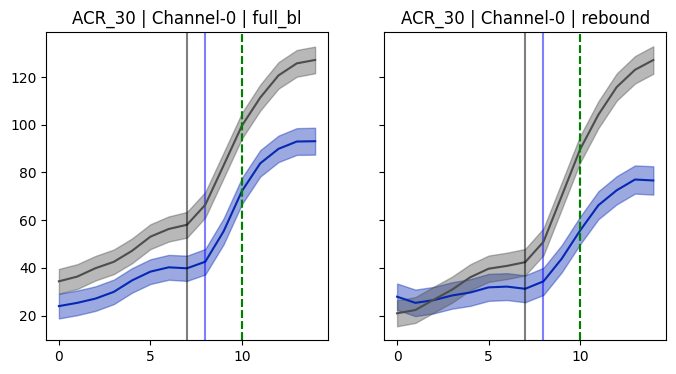

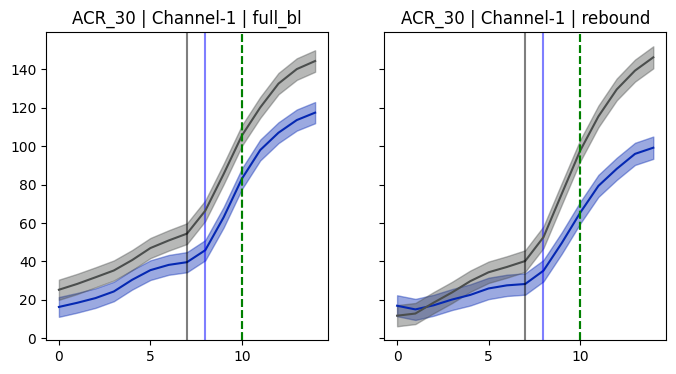

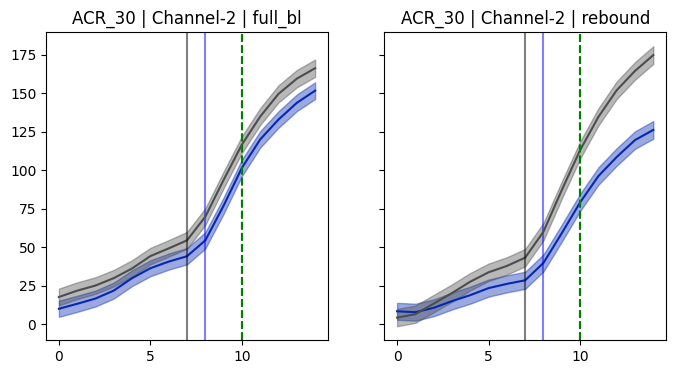

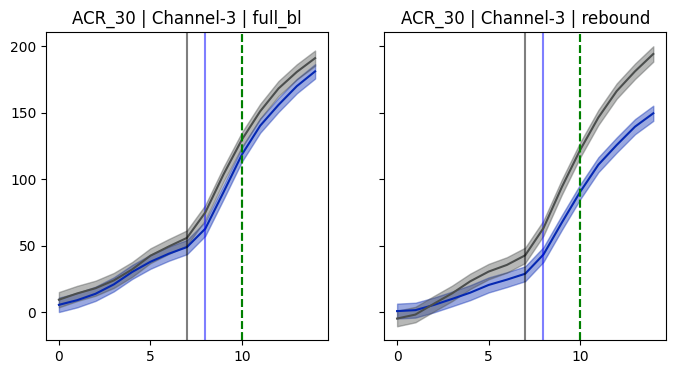

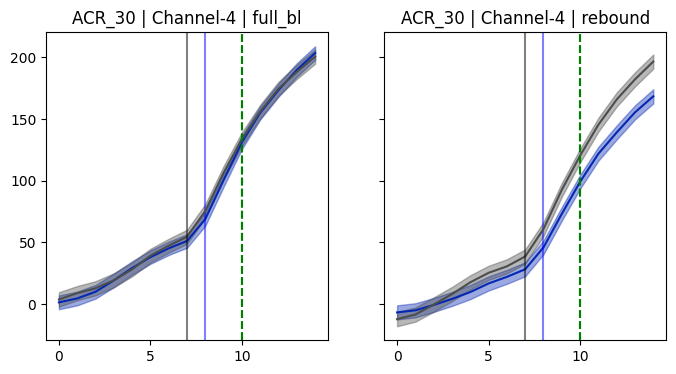

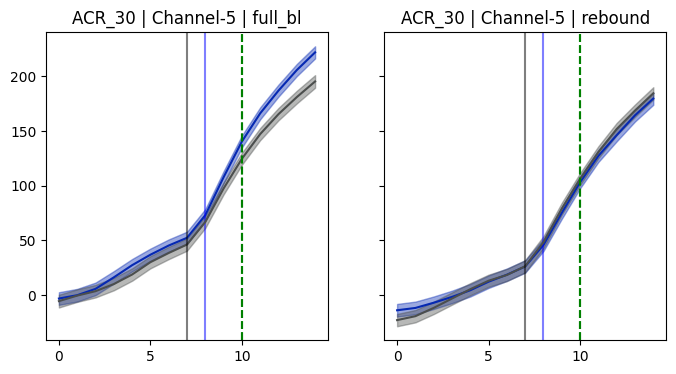

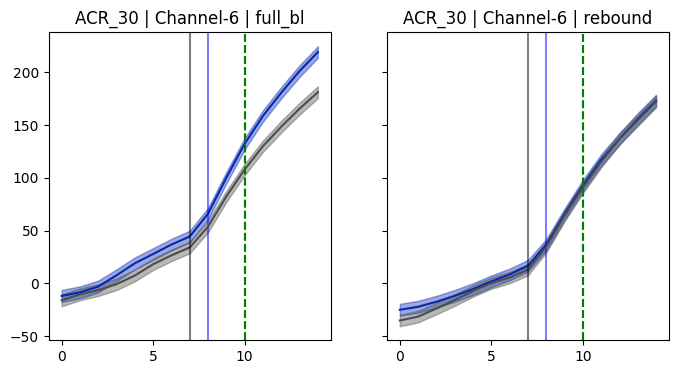

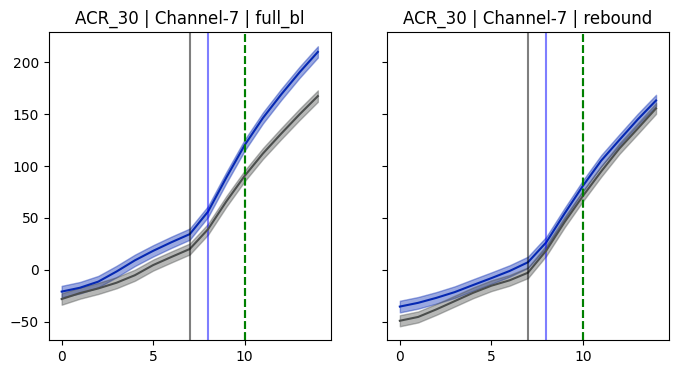

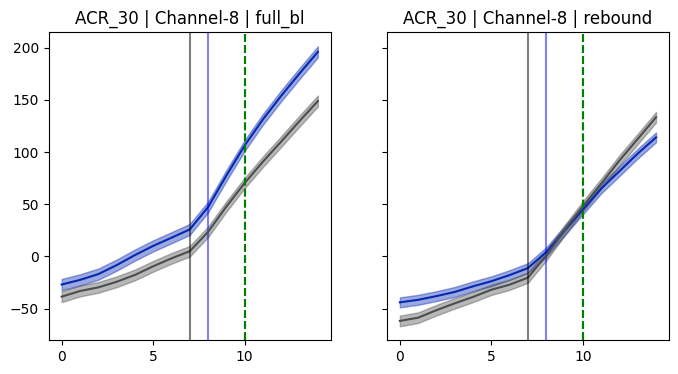

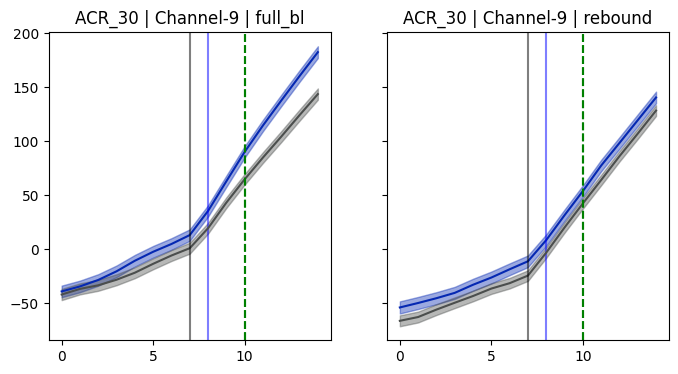

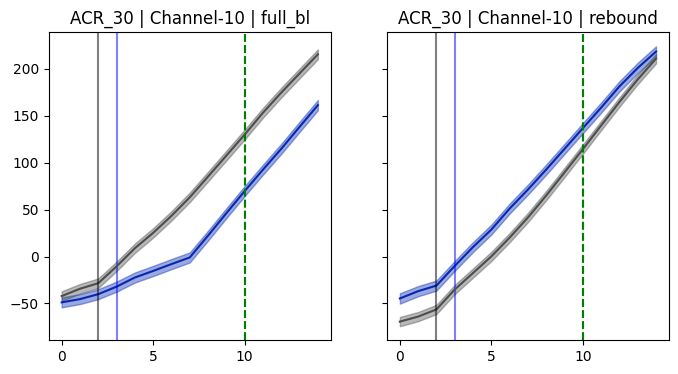

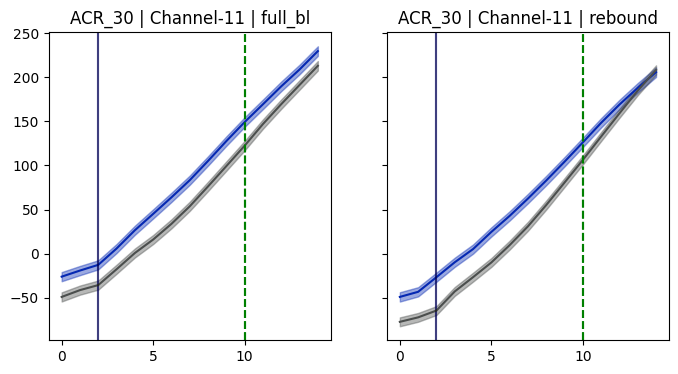

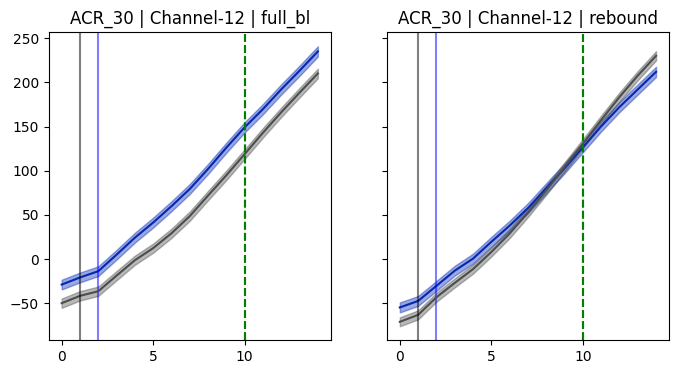

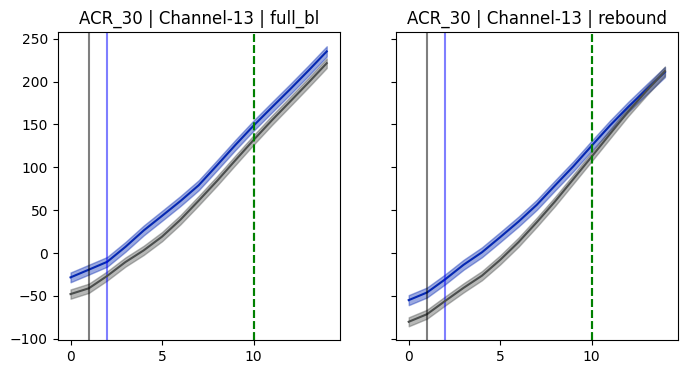

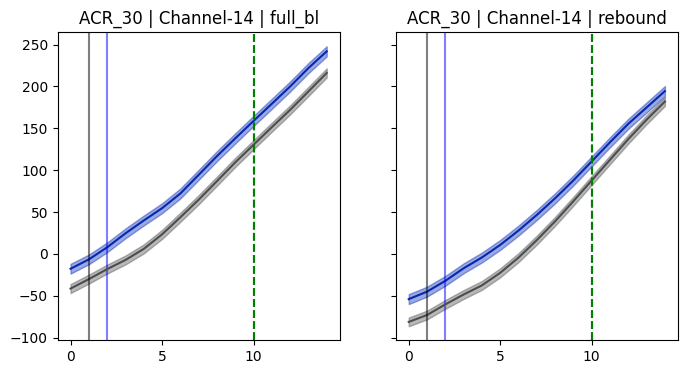

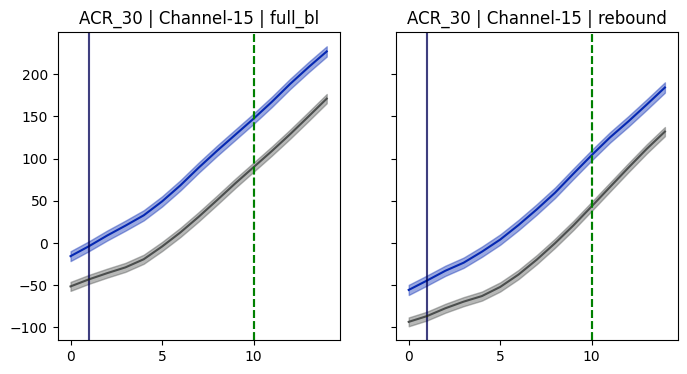

In [73]:
indices, init_avg, inits = get_onset_offset_aligned_data(init_traces, size=10, kind='max', fs=lfp.fs)
plt.rcdefaults()
p1 = 0
p2=15
for ch in range(16):
    f, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
    reb_len_nnxo = inits['NNXo']['rebound'].shape[2]
    reb_len_nnxr = inits['NNXr']['rebound'].shape[2]
    for i, cond in enumerate(['full_bl', 'rebound']):
        inits2p = inits['NNXo'][cond][ch, :, :1500]
        sems2p = np.std(inits2p, axis=1)/np.sqrt(inits2p.shape[1])
        d2p = inits2p.mean(axis=1)
        off_start_index = indices['NNXo']['rebound'][ch]
        ax[i].plot(d2p[p1:p2], color=SOM_BLUE)
        ax[i].fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=SOM_BLUE)
        ax[i].set_title(f'{subj} | Channel-{ch} | {cond}')
        ax[i].axvline(10, color='green', linestyle='--')
        ax[i].axvline(10-off_start_index, color='blue', alpha=0.5)

        inits2p = inits['NNXr'][cond][ch, :, :1500]
        sems2p = np.std(inits2p, axis=1)/np.sqrt(inits2p.shape[1])
        d2p = inits2p.mean(axis=1)
        off_start_index = indices['NNXr']['rebound'][ch]
        ax[i].plot(d2p[p1:p2], color=NNXR_GRAY)
        ax[i].axvline(10, color='green', linestyle='--')
        ax[i].fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=NNXR_GRAY)
        ax[i].set_title(f'{subj} | Channel-{ch} | {cond}')
        ax[i].axvline(10-off_start_index, color='black', alpha=0.5)

(-21.0, 210.0)

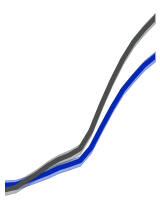

In [ ]:
indices, init_avg, inits = get_onset_offset_aligned_data(init_traces, size=10, kind='max', fs=lfp.fs)
ch = 3
p1=0
p2=15
cond = 'rebound'
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

f, ax = plt.subplots(1, 1, figsize=FSZ)

inits2p = inits['NNXo'][cond][ch, :, :1500]
sems2p = np.std(inits2p, axis=1)/np.sqrt(inits2p.shape[1])
d2p = inits2p.mean(axis=1)
off_start_index = indices['NNXo']['rebound'][ch]
ax.plot(d2p[p1:p2], color=SOM_BLUE, linewidth=lw)
ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=SOM_BLUE)

inits2p = inits['NNXr'][cond][ch, :, :1500]
sems2p =np.std(inits2p, axis=1)/np.sqrt(inits2p.shape[1])
d2p = inits2p.mean(axis=1)
off_start_index = indices['NNXr']['rebound'][ch]
ax.plot(d2p[p1:p2], color=NNXR_GRAY, linewidth=lw)

ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=NNXR_GRAY)


ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 14)
ax.set_ylim(-21, 210)
f.savefig(f'{notebook_figure_root}/acr_30__{cond}__off_initiation.png', dpi=600, bbox_inches='tight', transparent=True)

(-21.0, 210.0)

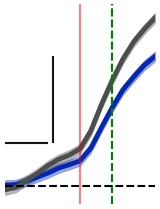

In [ ]:
indices, init_avg, inits = get_onset_offset_aligned_data(init_traces, size=10, kind='max', fs=lfp.fs)
ch = 3
p1=0
p2=15
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
cond = 'rebound'
f, ax = plt.subplots(1, 1, figsize=FSZ, sharey=True)

inits2p = inits['NNXo'][cond][ch, :, :1500]
sems2p = np.std(inits2p, axis=1)/np.sqrt(inits2p.shape[1])
d2p = inits2p.mean(axis=1)
off_start_index = indices['NNXo'][cond][ch]
ax.plot(d2p[p1:p2], color=SOM_BLUE, linewidth=lw)
ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=SOM_BLUE)
ax.axvline(10, color='green', linestyle='--')
#ax.axvline(10-off_start_index, color='blue', alpha=0.5)

inits2p = inits['NNXr'][cond][ch, :, :1500]
sems2p = np.std(inits2p, axis=1)/np.sqrt(inits2p.shape[1])
d2p = inits2p.mean(axis=1)
off_start_index = indices['NNXr'][cond][ch]
ax.plot(d2p[p1:p2], color=NNXR_GRAY, linewidth=lw)
ax.axvline(10, color='green', linestyle='--')
ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=NNXR_GRAY)
#ax.axvline(10-off_start_index, color='black', alpha=0.5)
ax.axvline(7, color='red', alpha=0.5)
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 14)

ax.hlines(y=50, xmin=0, xmax=4)
ax.vlines(x=4.5, ymin=50, ymax=150)
ax.set_ylim(-21, 210)
f.savefig(f'{notebook_figure_root}/acr_30__{cond}__off_initiation__SCALE-INFO__10ms__100uV.png', dpi=600, bbox_inches='tight', transparent=True)

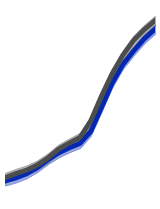

In [270]:
indices, init_avg, inits = get_onset_offset_aligned_data(init_traces, size=10, kind='max', fs=lfp.fs)
ch = 3
p1=0
p2=15
cond = 'full_bl'
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

f, ax = plt.subplots(1, 1, figsize=FSZ)

inits2p = inits['NNXo'][cond][ch, :, :1500]
sems2p = np.std(inits2p, axis=1)/np.sqrt(inits2p.shape[1])
d2p = inits2p.mean(axis=1)
off_start_index = indices['NNXo']['rebound'][ch]
ax.plot(d2p[p1:p2], color=SOM_BLUE, linewidth=lw)
ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=SOM_BLUE)

inits2p = inits['NNXr'][cond][ch, :, :1500]
sems2p = np.std(inits2p, axis=1)/np.sqrt(inits2p.shape[1])
d2p = inits2p.mean(axis=1)
off_start_index = indices['NNXr']['rebound'][ch]
ax.plot(d2p[p1:p2], color=NNXR_GRAY, linewidth=lw)

ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=NNXR_GRAY)


ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 14)
ax.set_ylim(-21, 210)
f.savefig(f'{notebook_figure_root}/acr_30__{cond}__off_initiation.png', dpi=600, bbox_inches='tight', transparent=True)

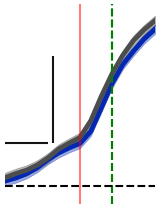

In [271]:
indices, init_avg, inits = get_onset_offset_aligned_data(init_traces, size=10, kind='max', fs=lfp.fs)
ch = 3
p1=0
p2=15
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
cond = 'full_bl'
f, ax = plt.subplots(1, 1, figsize=FSZ, sharey=True)

inits2p = inits['NNXo'][cond][ch, :, :1500]
sems2p = np.std(inits2p, axis=1)/np.sqrt(inits2p.shape[1])
d2p = inits2p.mean(axis=1)
off_start_index = indices['NNXo'][cond][ch]
ax.plot(d2p[p1:p2], color=SOM_BLUE, linewidth=lw)
ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=SOM_BLUE)
ax.axvline(10, color='green', linestyle='--')
#ax.axvline(10-off_start_index, color='blue', alpha=0.5)

inits2p = inits['NNXr'][cond][ch, :, :1500]
sems2p = np.std(inits2p, axis=1)/np.sqrt(inits2p.shape[1])
d2p = inits2p.mean(axis=1)
off_start_index = indices['NNXr'][cond][ch]
ax.plot(d2p[p1:p2], color=NNXR_GRAY, linewidth=lw)
ax.axvline(10, color='green', linestyle='--')
ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=NNXR_GRAY)
#ax.axvline(10-off_start_index, color='black', alpha=0.5)
ax.axvline(7, color='red', alpha=0.5)
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 14)

ax.hlines(y=50, xmin=0, xmax=4)
ax.vlines(x=4.5, ymin=50, ymax=150)
ax.set_ylim(-21, 210)
f.savefig(f'{notebook_figure_root}/acr_30__{cond}__off_initiation__SCALE-INFO__10ms__100uV.png', dpi=600, bbox_inches='tight', transparent=True)

# Termination Slopes

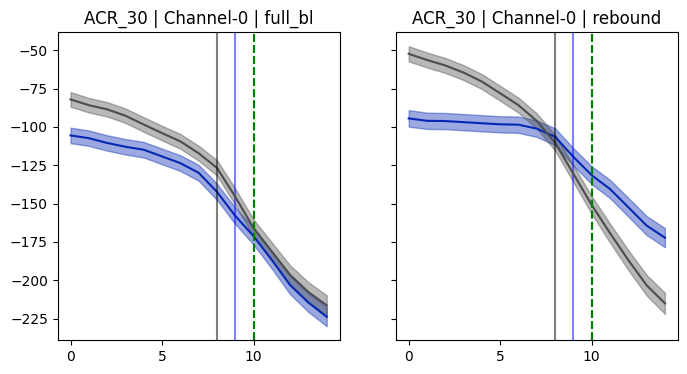

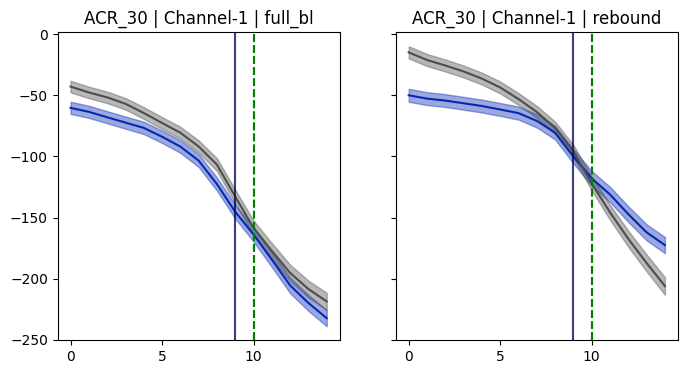

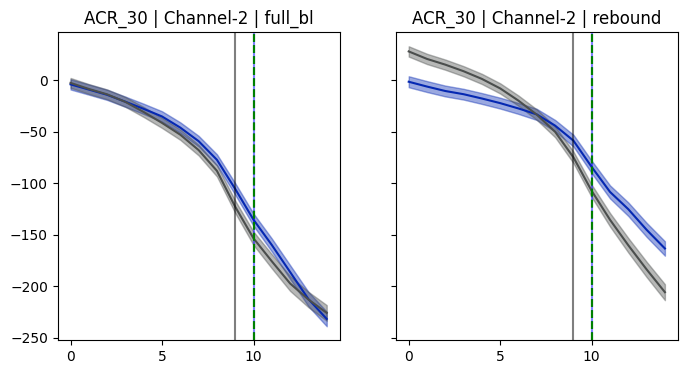

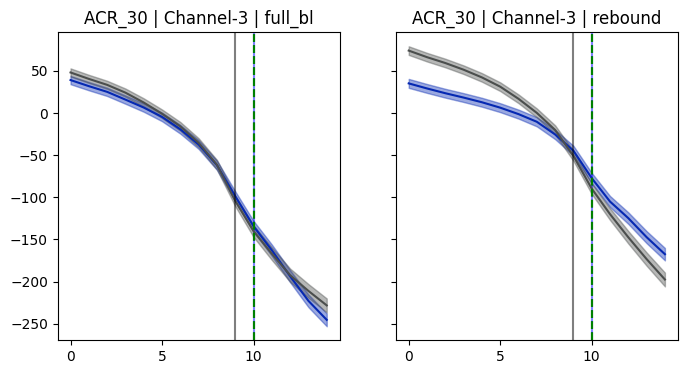

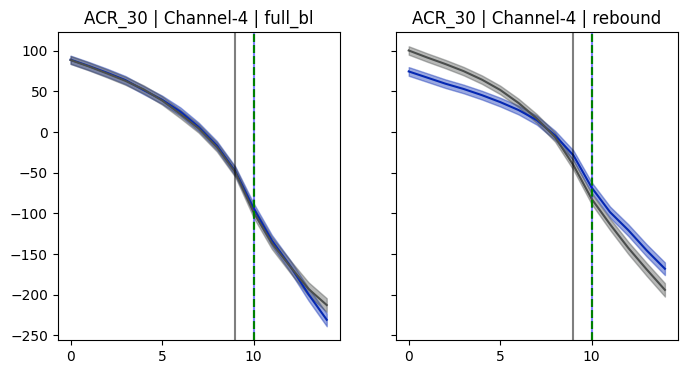

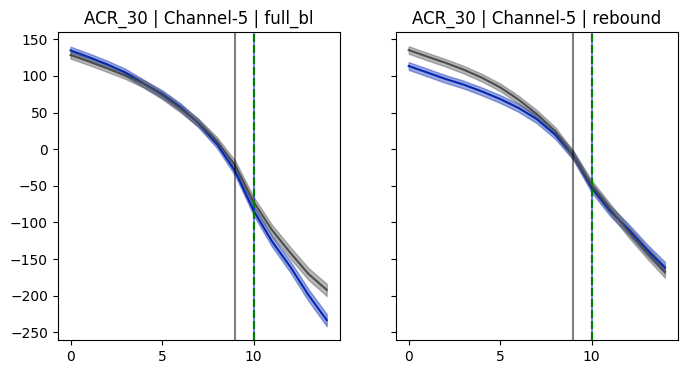

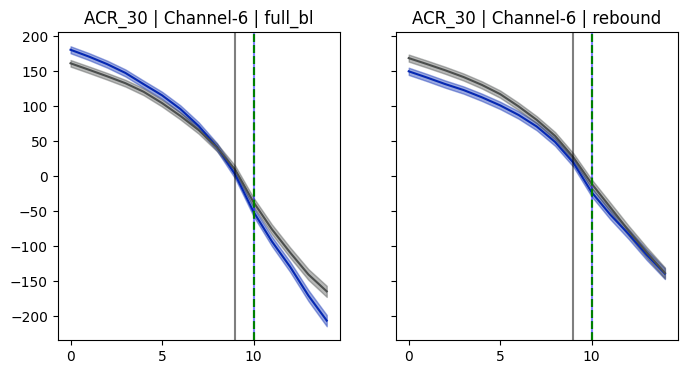

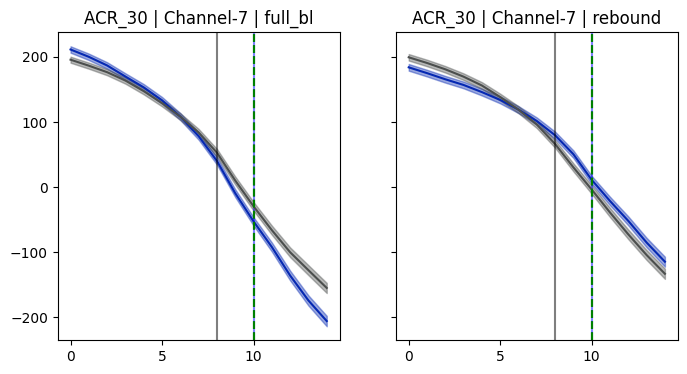

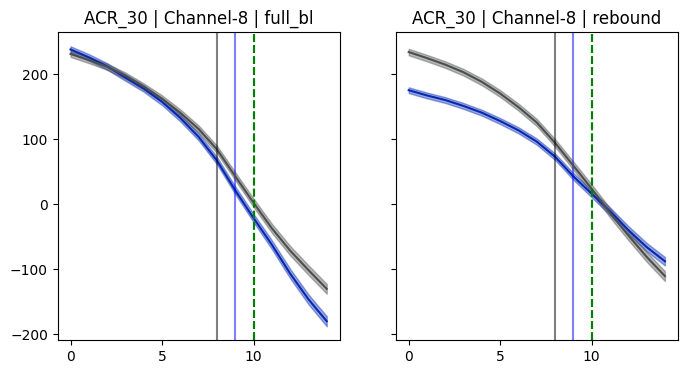

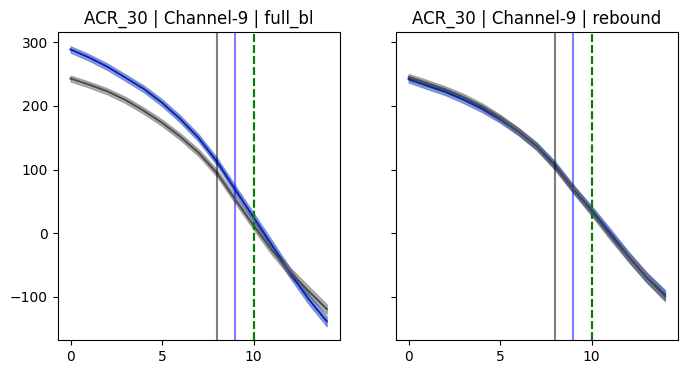

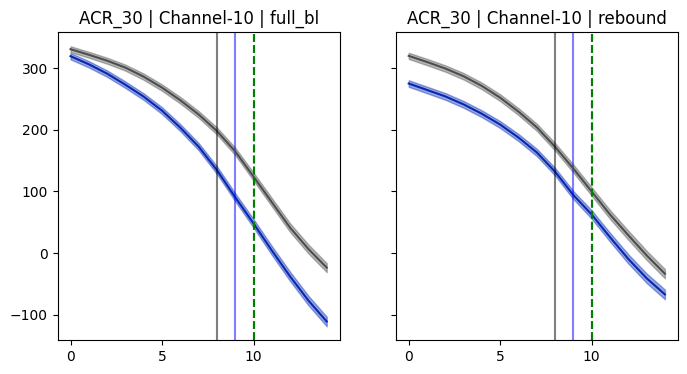

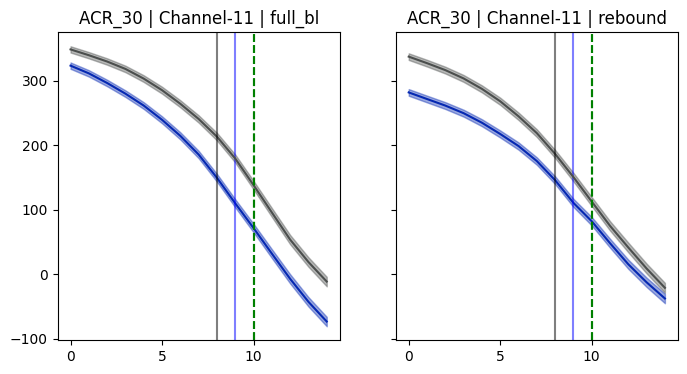

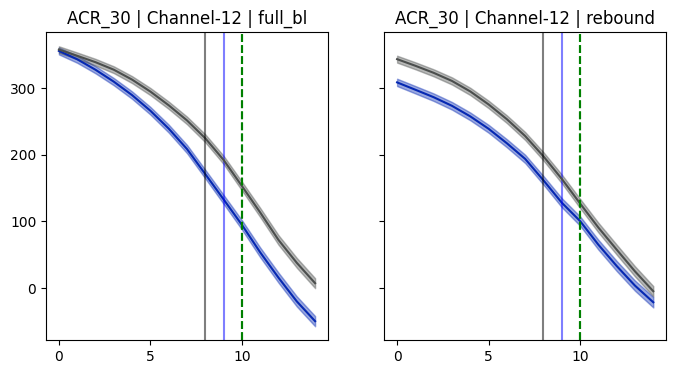

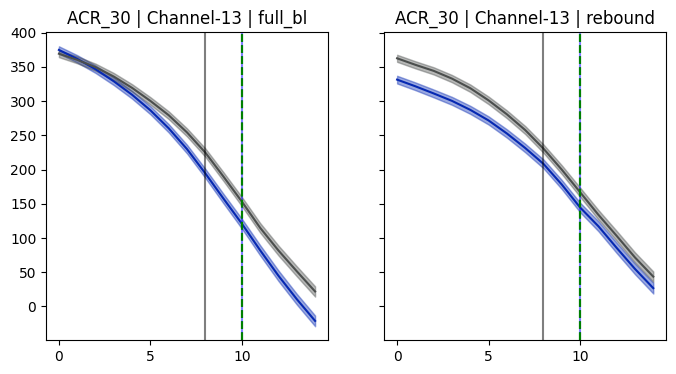

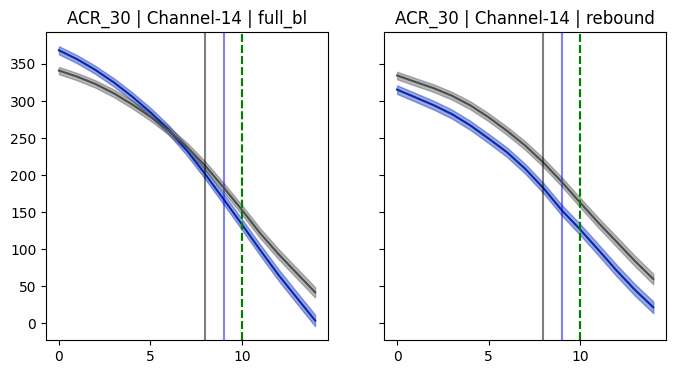

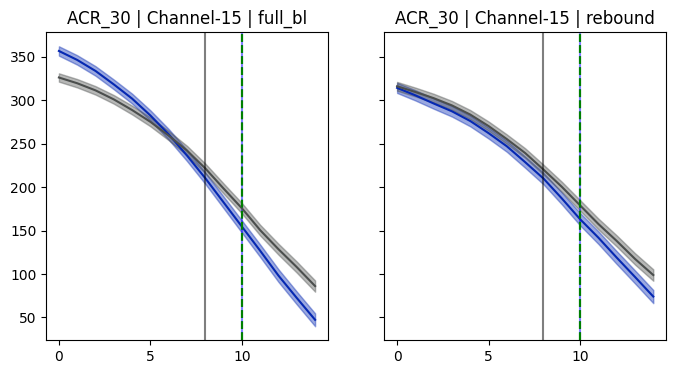

In [46]:
indices, term_avg, terms = get_onset_offset_aligned_data(term_traces, size=10, kind='min', fs=lfp.fs)
p1 = 0
p2=15
for ch in range(16):
    f, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
    reb_len_nnxo = terms['NNXo']['rebound'].shape[2]
    reb_len_nnxr = terms['NNXr']['rebound'].shape[2]
    for i, cond in enumerate(['full_bl', 'rebound']):
        terms2p = terms['NNXo'][cond][ch, :, :1500]
        sems2p = np.std(terms2p, axis=1)/np.sqrt(terms2p.shape[1])
        d2p = terms2p.mean(axis=1)
        off_start_index = indices['NNXo']['rebound'][ch]
        ax[i].plot(d2p[p1:p2], color=SOM_BLUE)
        ax[i].fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=SOM_BLUE)
        ax[i].set_title(f'{subj} | Channel-{ch} | {cond}')
        ax[i].axvline(10, color='green', linestyle='--')
        ax[i].axvline(10-off_start_index, color='blue', alpha=0.5)

        terms2p = terms['NNXr'][cond][ch, :, :1500]
        sems2p = np.std(terms2p, axis=1)/np.sqrt(terms2p.shape[1])
        d2p = terms2p.mean(axis=1)
        off_start_index = indices['NNXr']['rebound'][ch]
        ax[i].plot(d2p[p1:p2], color=NNXR_GRAY)
        ax[i].axvline(10, color='green', linestyle='--')
        ax[i].fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=NNXR_GRAY)
        ax[i].set_title(f'{subj} | Channel-{ch} | {cond}')
        ax[i].axvline(10-off_start_index, color='black', alpha=0.5)

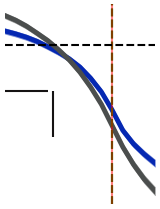

In [272]:
indices, term_avg, terms = get_onset_offset_aligned_data(term_traces, size=10, kind='min', fs=lfp.fs)
cond = 'rebound'
ch = 3
p1=0
p2=15
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

f, ax = plt.subplots(1, 1, figsize=FSZ, sharey=True)

terms2p = terms['NNXo'][cond][ch, :, :1500]
sems2p = np.std(terms2p, axis=1)/np.sqrt(terms2p.shape[1])
d2p = terms2p.mean(axis=1)
off_start_index = indices['NNXo']['rebound'][ch]
ax.plot(d2p[p1:p2], color=SOM_BLUE, linewidth=lw)
ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=SOM_BLUE)
ax.axvline(10, color='green', linestyle='--')
#ax.axvline(10-off_start_index, color='blue', alpha=0.5)

terms2p = terms['NNXr'][cond][ch, :, :1500]
sems2p = np.std(terms2p, axis=1)/np.sqrt(terms2p.shape[1])
d2p = terms2p.mean(axis=1)
off_start_index = indices['NNXr']['rebound'][ch]
ax.plot(d2p[p1:p2], color=NNXR_GRAY, linewidth=lw)
ax.axvline(10, color='green', linestyle='--')
ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=NNXR_GRAY)
#ax.axvline(10-off_start_index, color='black', alpha=0.5)
ax.axvline(10, color='red', alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 14)
ax.axhline(y=0, color='black', linestyle='--')
ax.hlines(y=-100, xmin=0, xmax=4)
ax.vlines(x=4.5, ymin=-200, ymax=-100)
ax.set_ylim(-344, 89)
f.savefig(f'{notebook_figure_root}/acr_30__{cond}__off_termiation__SCALE-INFO__10ms__100uV.png', dpi=600, bbox_inches='tight', transparent=True)

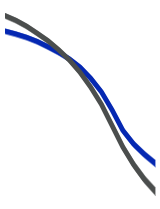

In [273]:
indices, term_avg, terms = get_onset_offset_aligned_data(term_traces, size=10, kind='min', fs=lfp.fs)
ch = 3
p1=0
p2=15
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
cond = 'rebound'
f, ax = plt.subplots(1, 1, figsize=FSZ, sharey=True)

terms2p = terms['NNXo'][cond][ch, :, :1500]
sems2p = np.std(terms2p, axis=1)/np.sqrt(terms2p.shape[1])
d2p = terms2p.mean(axis=1)
off_start_index = indices['NNXo']['rebound'][ch]
ax.plot(d2p[p1:p2], color=SOM_BLUE, linewidth=lw)
ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=SOM_BLUE)

#ax.axvline(10-off_start_index, color='blue', alpha=0.5)

terms2p = terms['NNXr'][cond][ch, :, :1500]
sems2p = np.std(terms2p, axis=1)/np.sqrt(terms2p.shape[1])
d2p = terms2p.mean(axis=1)
off_start_index = indices['NNXr']['rebound'][ch]
ax.plot(d2p[p1:p2], color=NNXR_GRAY, linewidth=lw)

ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=NNXR_GRAY)
#ax.axvline(10-off_start_index, color='black', alpha=0.5)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 14)
ax.set_ylim(-344, 89)

f.savefig(f'{notebook_figure_root}/acr_30__{cond}__off_termiation.png', dpi=600, bbox_inches='tight', transparent=True)

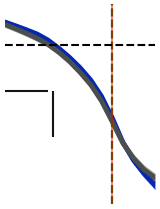

In [274]:
indices, term_avg, terms = get_onset_offset_aligned_data(term_traces, size=10, kind='min', fs=lfp.fs)
cond = 'full_bl'
ch = 3
p1=0
p2=15
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

f, ax = plt.subplots(1, 1, figsize=FSZ, sharey=True)

terms2p = terms['NNXo'][cond][ch, :, :1500]
sems2p = np.std(terms2p, axis=1)/np.sqrt(terms2p.shape[1])
d2p = terms2p.mean(axis=1)
off_start_index = indices['NNXo']['rebound'][ch]
ax.plot(d2p[p1:p2], color=SOM_BLUE, linewidth=lw)
ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=SOM_BLUE)
ax.axvline(10, color='green', linestyle='--')
#ax.axvline(10-off_start_index, color='blue', alpha=0.5)

terms2p = terms['NNXr'][cond][ch, :, :1500]
sems2p = np.std(terms2p, axis=1)/np.sqrt(terms2p.shape[1])
d2p = terms2p.mean(axis=1)
off_start_index = indices['NNXr']['rebound'][ch]
ax.plot(d2p[p1:p2], color=NNXR_GRAY, linewidth=lw)
ax.axvline(10, color='green', linestyle='--')
ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=NNXR_GRAY)
#ax.axvline(10-off_start_index, color='black', alpha=0.5)
ax.axvline(10, color='red', alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 14)
ax.axhline(y=0, color='black', linestyle='--')
ax.hlines(y=-100, xmin=0, xmax=4)
ax.vlines(x=4.5, ymin=-200, ymax=-100)
ax.set_ylim(-344, 89)
f.savefig(f'{notebook_figure_root}/acr_30__{cond}__off_termiation__SCALE-INFO__10ms__100uV.png', dpi=600, bbox_inches='tight', transparent=True)

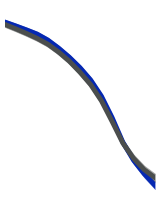

In [275]:
indices, term_avg, terms = get_onset_offset_aligned_data(term_traces, size=10, kind='min', fs=lfp.fs)
ch = 3
p1=0
p2=15
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
cond = 'full_bl'
f, ax = plt.subplots(1, 1, figsize=FSZ, sharey=True)

terms2p = terms['NNXo'][cond][ch, :, :1500]
sems2p = np.std(terms2p, axis=1)/np.sqrt(terms2p.shape[1])
d2p = terms2p.mean(axis=1)
off_start_index = indices['NNXo']['rebound'][ch]
ax.plot(d2p[p1:p2], color=SOM_BLUE, linewidth=lw)
ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=SOM_BLUE)

#ax.axvline(10-off_start_index, color='blue', alpha=0.5)

terms2p = terms['NNXr'][cond][ch, :, :1500]
sems2p = np.std(terms2p, axis=1)/np.sqrt(terms2p.shape[1])
d2p = terms2p.mean(axis=1)
off_start_index = indices['NNXr']['rebound'][ch]
ax.plot(d2p[p1:p2], color=NNXR_GRAY, linewidth=lw)

ax.fill_between(range(d2p[p1:p2].shape[0]), d2p[p1:p2] - sems2p[p1:p2], d2p[p1:p2] + sems2p[p1:p2], alpha=0.4, color=NNXR_GRAY)
#ax.axvline(10-off_start_index, color='black', alpha=0.5)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 14)
ax.set_ylim(-344, 89)

f.savefig(f'{notebook_figure_root}/acr_30__{cond}__off_termiation.png', dpi=600, bbox_inches='tight', transparent=True)

# Peak Traces

In [ ]:
traces = {}
buffer = .18
for probe in ['NNXo', 'NNXr']:
    traces[probe] = {}
    data = raw_lfps[subject].prb(probe)
    oodf = oodfs[subject].prb(probe)
    for condition in ['rebound', 'circ_bl']:
        off_starts = oodf.cdn(condition)['start_datetime'].to_pandas()
        off_durs = oodf.cdn(condition)['duration'].to_pandas()
        if len(off_starts) == 0:
            continue
        traces[probe][condition] = acr.sync.select_data_for_peaks(off_starts, off_durs, data, buffer=buffer)
    for full_bl_val in ['True']:
        off_starts = oodf.filter(pl.col('full_bl')==full_bl_val)['start_datetime'].to_pandas()
        off_durs = oodf.filter(pl.col('full_bl')==full_bl_val)['duration'].to_pandas()
        traces[probe]['full_bl'] = acr.sync.select_data_for_peaks(off_starts, off_durs, data, buffer=buffer)
indices, peak_aligned, trial_aligned = get_peak_aligned_data(traces, size=56)

(-325.0, 228.0)

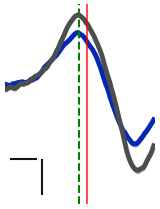

In [16]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
chan = 4
cond = 'rebound'
f, ax = plt.subplots(1, 1, figsize=FSZ, sharey=True)
nnxr_reb_length = trial_aligned['NNXr']['rebound'].shape[2]
nnxo_reb_length = trial_aligned['NNXo']['rebound'].shape[2]

pkdat = trial_aligned['NNXo'][cond][chan, :, :1500]
peaks2p = pkdat.mean(axis=1)
peak_sem = np.std(pkdat, axis=1)/np.sqrt(pkdat.shape[1])
ax.plot(peaks2p, color=SOM_BLUE, linewidth=lw)
ax.fill_between(range(peaks2p.shape[0]), peaks2p - peak_sem, peaks2p + peak_sem, alpha=0.4, color=SOM_BLUE)
ax.axvline(56, color='green', linestyle='--')
midpoint = indices['NNXo'][cond][chan]
#ax.axvline(56-midpoint, color='blue', alpha=0.5)




pkdat = trial_aligned['NNXr'][cond][chan, :, :1500]
peaks2p = pkdat.mean(axis=1)
peak_sem = np.std(pkdat, axis=1)/np.sqrt(pkdat.shape[1])
ax.plot(peaks2p, color=NNXR_GRAY, linewidth=lw)
ax.fill_between(range(peaks2p.shape[0]), peaks2p - peak_sem, peaks2p + peak_sem, alpha=0.4, color=NNXR_GRAY)
midpoint = indices['NNXr'][cond][chan]
ax.axvline(56-midpoint, color='red', alpha=0.7)

ax.hlines(y=-200, xmin=4, xmax=24)
ax.vlines(x=28, ymin=-300, ymax=-200)
ax.set_xlim(0, 113)
ax.set_ylim(-325, 228)
f.savefig(f'{notebook_figure_root}/acr_30__{cond}__PEAK__SCALE-INFO__50ms__100uV.png', dpi=600, bbox_inches='tight', transparent=True)

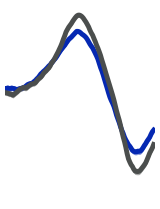

In [265]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
chan = 4
cond = 'rebound'
f, ax = plt.subplots(1, 1, figsize=FSZ, sharey=True)
nnxr_reb_length = trial_aligned['NNXr']['rebound'].shape[2]
nnxo_reb_length = trial_aligned['NNXo']['rebound'].shape[2]

pkdat = trial_aligned['NNXo'][cond][chan, :, :1500]
peaks2p = pkdat.mean(axis=1)
peak_sem = np.std(pkdat, axis=1)/np.sqrt(pkdat.shape[1])
ax.plot(peaks2p, color=SOM_BLUE, linewidth=lw)
ax.fill_between(range(peaks2p.shape[0]), peaks2p - peak_sem, peaks2p + peak_sem, alpha=0.4, color=SOM_BLUE)

midpoint = indices['NNXo'][cond][chan]




pkdat = trial_aligned['NNXr'][cond][chan, :, :1500]
peaks2p = pkdat.mean(axis=1)
peak_sem = np.std(pkdat, axis=1)/np.sqrt(pkdat.shape[1])
ax.plot(peaks2p, color=NNXR_GRAY, linewidth=lw)
ax.fill_between(range(peaks2p.shape[0]), peaks2p - peak_sem, peaks2p + peak_sem, alpha=0.4, color=NNXR_GRAY)
midpoint = indices['NNXr'][cond][chan]

ax.set_xlim(0, 113)
ax.set_ylim(-325, 228)
f.savefig(f'{notebook_figure_root}/acr_30__{cond}__PEAK.png', dpi=600, bbox_inches='tight', transparent=True)

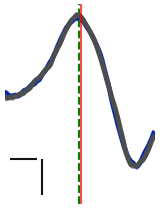

In [266]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
chan = 4
cond = 'full_bl'
f, ax = plt.subplots(1, 1, figsize=FSZ, sharey=True)
nnxr_reb_length = trial_aligned['NNXr']['rebound'].shape[2]
nnxo_reb_length = trial_aligned['NNXo']['rebound'].shape[2]

pkdat = trial_aligned['NNXo'][cond][chan, :, :1500]
peaks2p = pkdat.mean(axis=1)
peak_sem = np.std(pkdat, axis=1)/np.sqrt(pkdat.shape[1])
ax.plot(peaks2p, color=SOM_BLUE, linewidth=lw)
ax.fill_between(range(peaks2p.shape[0]), peaks2p - peak_sem, peaks2p + peak_sem, alpha=0.4, color=SOM_BLUE)
ax.axvline(56, color='green', linestyle='--')
midpoint = indices['NNXo'][cond][chan]
#ax.axvline(56-midpoint, color='blue', alpha=0.5)




pkdat = trial_aligned['NNXr'][cond][chan, :, :1500]
peaks2p = pkdat.mean(axis=1)
peak_sem = np.std(pkdat, axis=1)/np.sqrt(pkdat.shape[1])
ax.plot(peaks2p, color=NNXR_GRAY, linewidth=lw)
ax.fill_between(range(peaks2p.shape[0]), peaks2p - peak_sem, peaks2p + peak_sem, alpha=0.4, color=NNXR_GRAY)
midpoint = indices['NNXr'][cond][chan]
ax.axvline(56-midpoint, color='red', alpha=0.7)

ax.hlines(y=-200, xmin=4, xmax=24)
ax.vlines(x=28, ymin=-300, ymax=-200)
ax.set_xlim(0, 113)
ax.set_ylim(-325, 228)
f.savefig(f'{notebook_figure_root}/acr_30__{cond}__PEAK__SCALE-INFO__50ms__100uV.png', dpi=600, bbox_inches='tight', transparent=True)

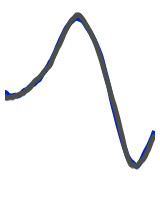

In [267]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
chan = 4
cond = 'full_bl'
f, ax = plt.subplots(1, 1, figsize=FSZ, sharey=True)
nnxr_reb_length = trial_aligned['NNXr']['rebound'].shape[2]
nnxo_reb_length = trial_aligned['NNXo']['rebound'].shape[2]

pkdat = trial_aligned['NNXo'][cond][chan, :, :1500]
peaks2p = pkdat.mean(axis=1)
peak_sem = np.std(pkdat, axis=1)/np.sqrt(pkdat.shape[1])
ax.plot(peaks2p, color=SOM_BLUE, linewidth=lw)
ax.fill_between(range(peaks2p.shape[0]), peaks2p - peak_sem, peaks2p + peak_sem, alpha=0.4, color=SOM_BLUE)

midpoint = indices['NNXo'][cond][chan]




pkdat = trial_aligned['NNXr'][cond][chan, :, :1500]
peaks2p = pkdat.mean(axis=1)
peak_sem = np.std(pkdat, axis=1)/np.sqrt(pkdat.shape[1])
ax.plot(peaks2p, color=NNXR_GRAY, linewidth=lw)
ax.fill_between(range(peaks2p.shape[0]), peaks2p - peak_sem, peaks2p + peak_sem, alpha=0.4, color=NNXR_GRAY)
midpoint = indices['NNXr'][cond][chan]

ax.set_xlim(0, 113)
ax.set_ylim(-325, 228)
f.savefig(f'{notebook_figure_root}/acr_30__{cond}__PEAK.png', dpi=600, bbox_inches='tight', transparent=True)

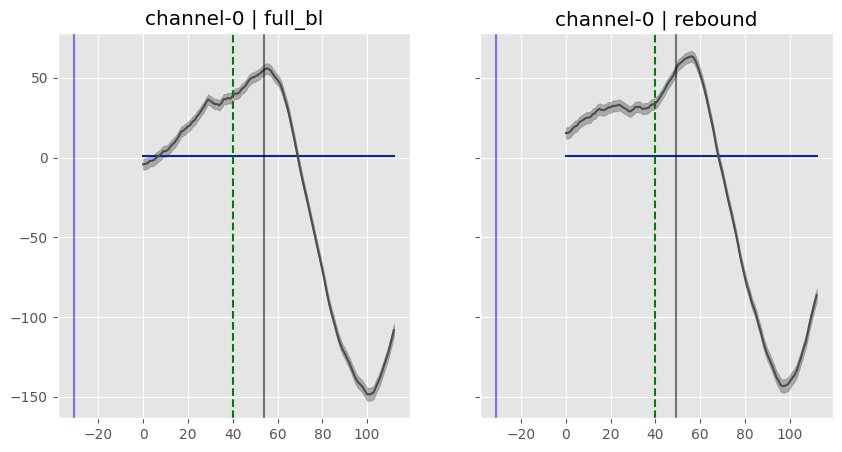

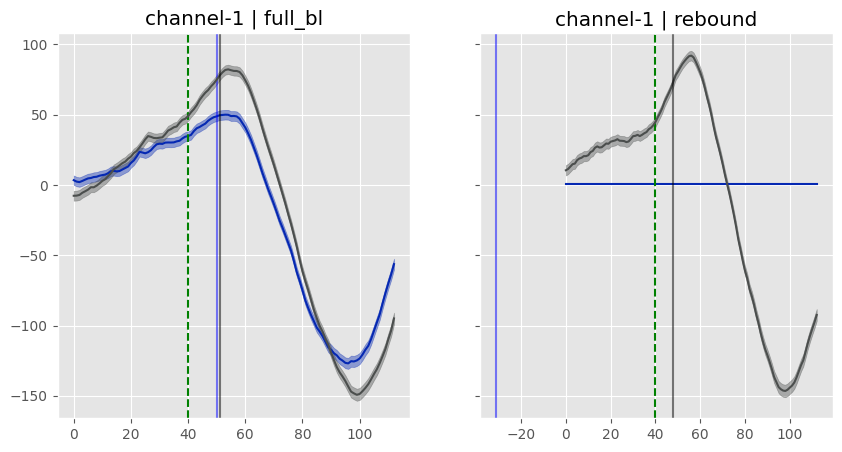

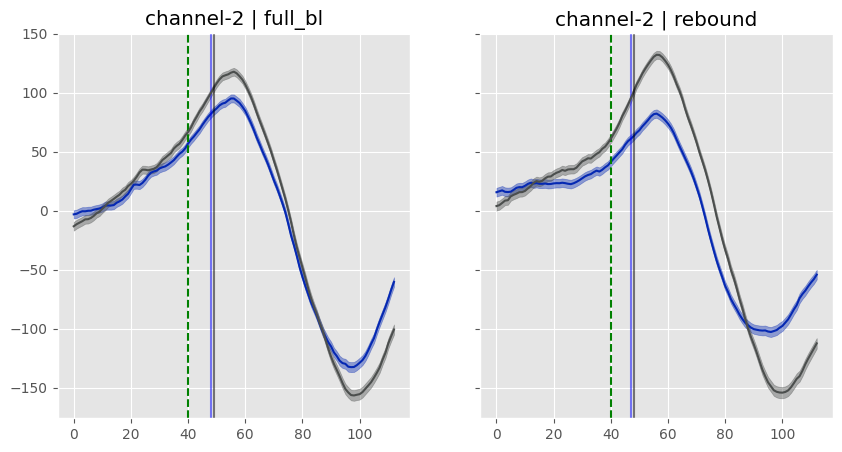

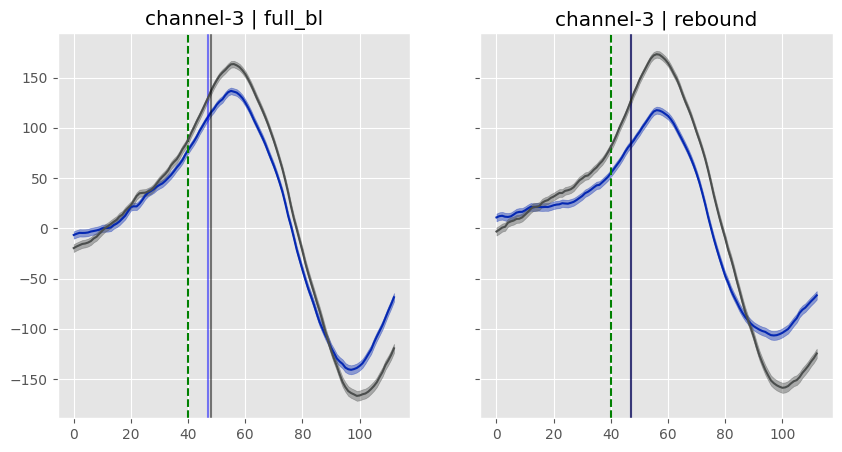

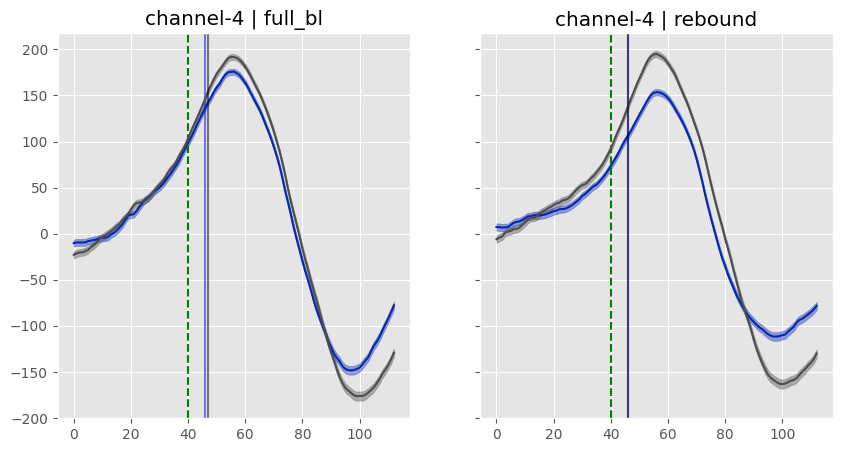

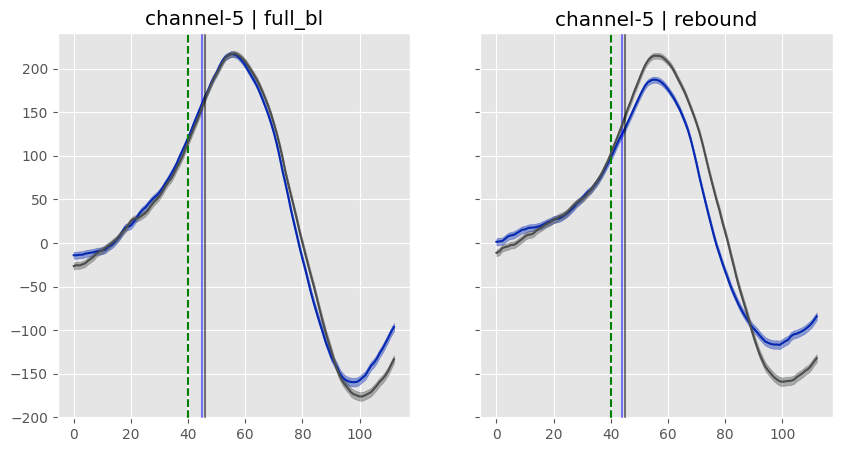

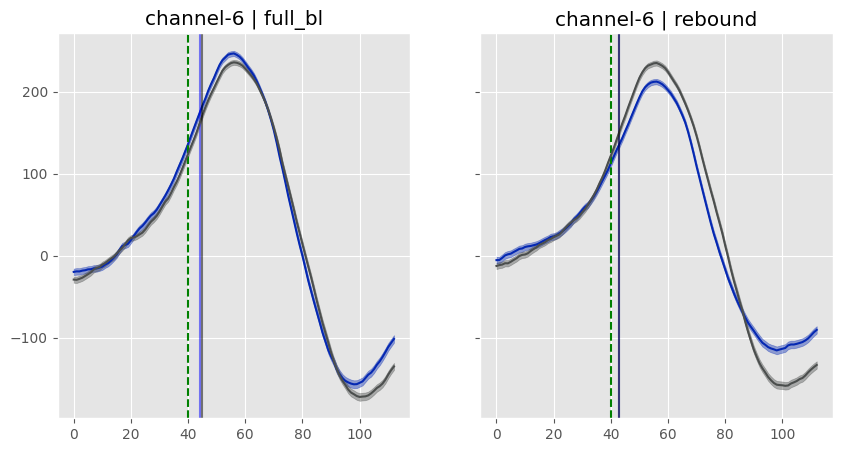

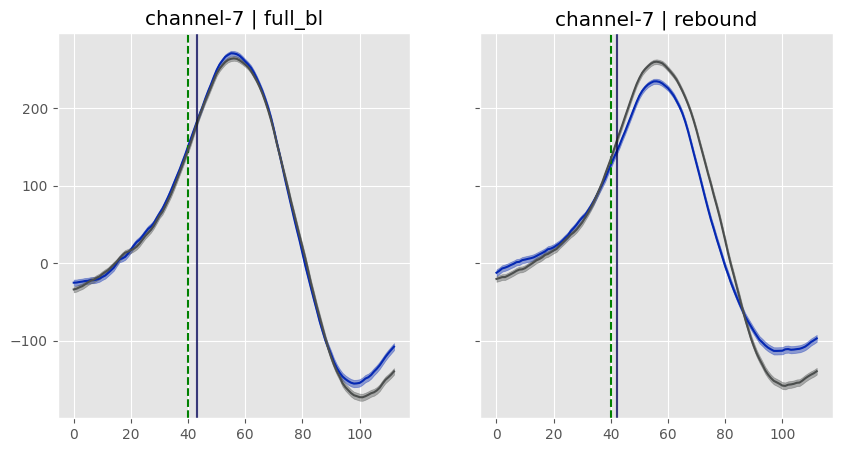

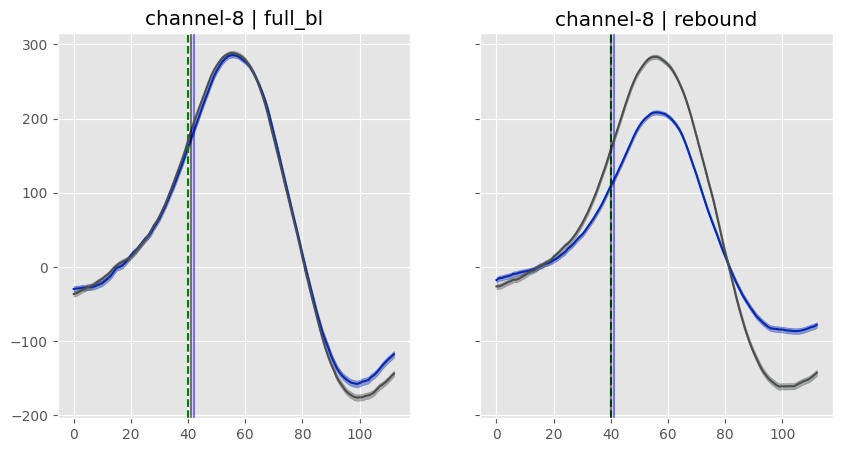

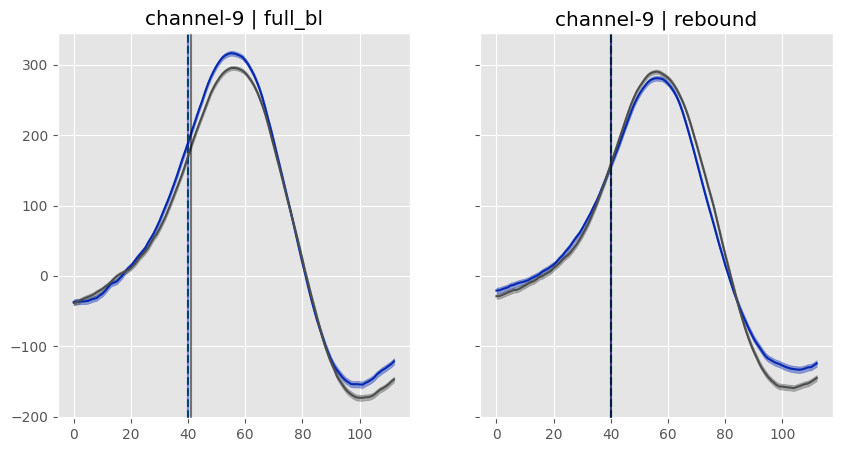

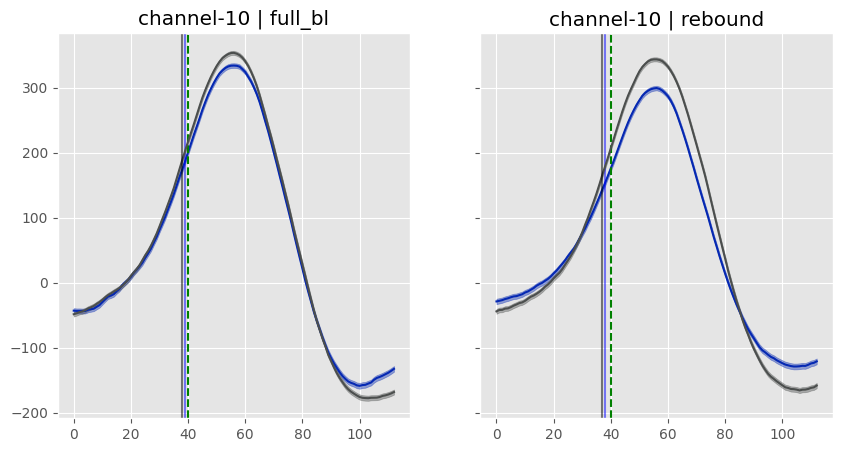

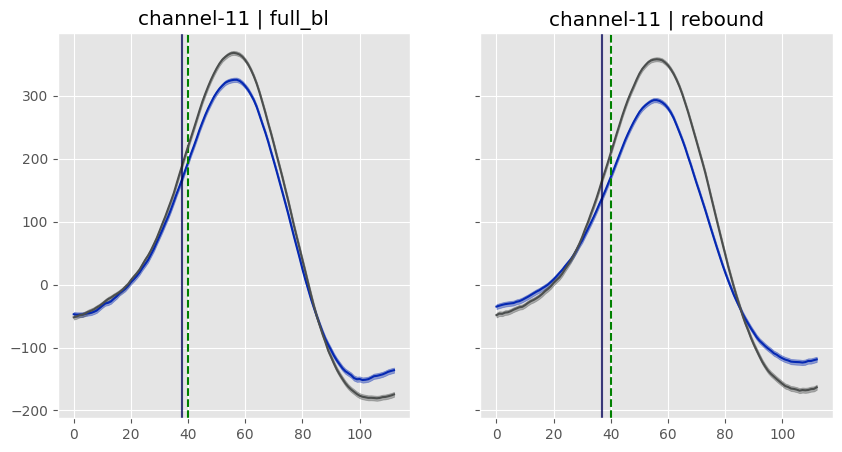

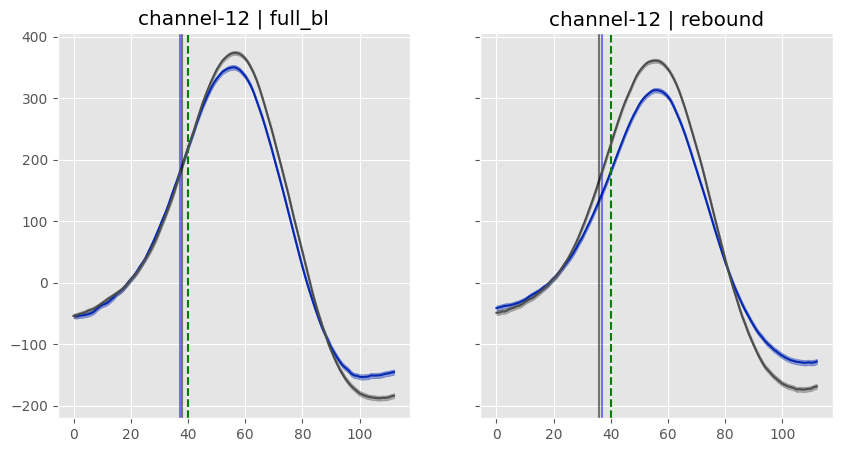

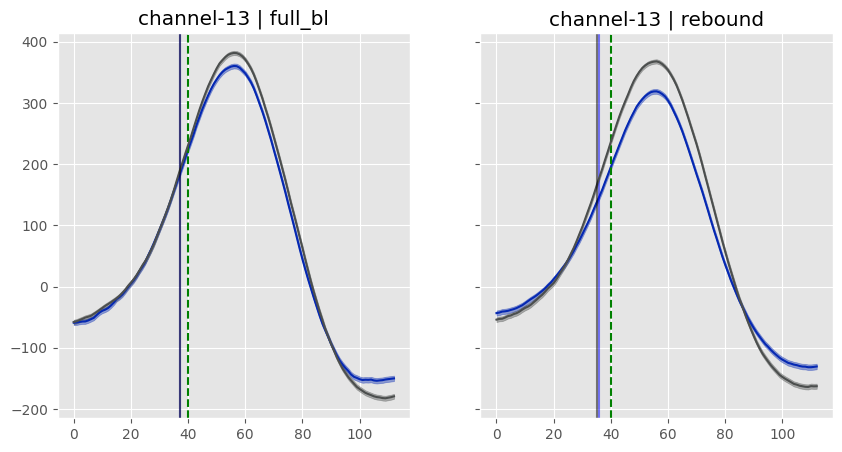

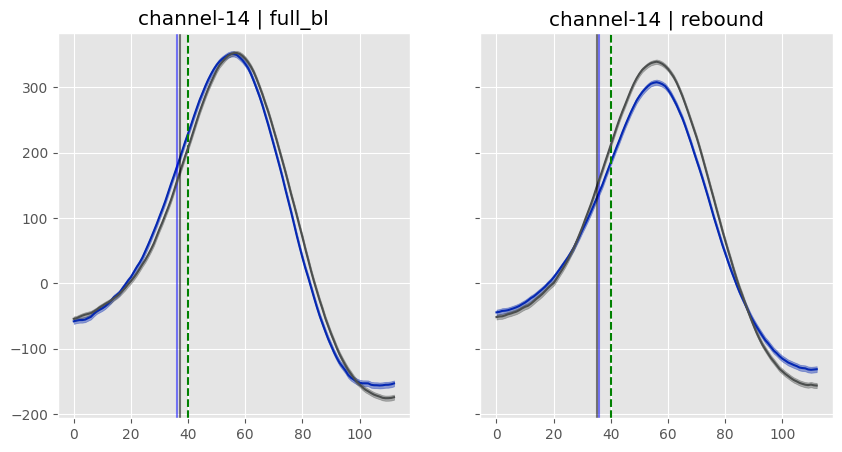

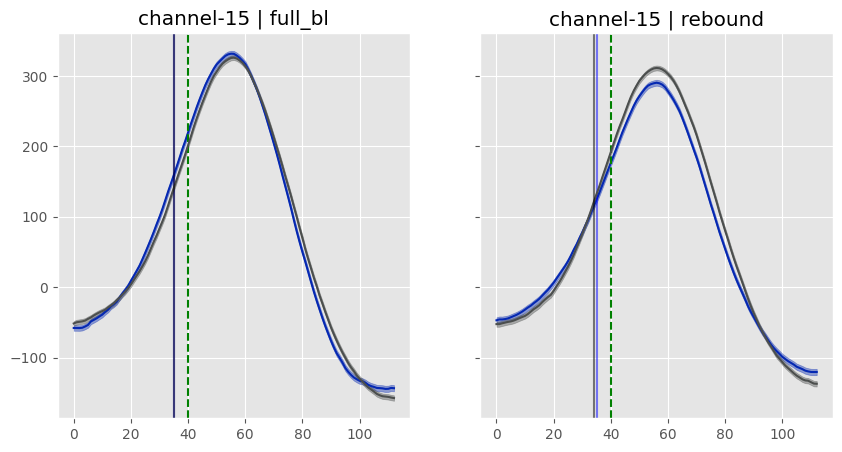

In [17]:
plt.rcdefaults()
plt.style.use('ggplot')
for chan in range(16):
    f, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    nnxr_reb_length = trial_aligned['NNXr']['rebound'].shape[2]
    nnxo_reb_length = trial_aligned['NNXo']['rebound'].shape[2]
    for i, cond in enumerate(['full_bl', 'rebound']):
        pkdat = trial_aligned['NNXo'][cond][chan, :, :nnxr_reb_length]
        peaks2p = pkdat.mean(axis=1)
        peak_sem = np.std(pkdat, axis=1)/np.sqrt(pkdat.shape[1])
        ax[i].plot(peaks2p, color=SOM_BLUE)
        ax[i].fill_between(range(peaks2p.shape[0]), peaks2p - peak_sem, peaks2p + peak_sem, alpha=0.4, color=SOM_BLUE)
        ax[i].axvline(40, color='green', linestyle='--')
        midpoint = indices['NNXo'][cond][chan]
        ax[i].axvline(40-midpoint, color='blue', alpha=0.5)
        ax[i].set_title(f'channel-{chan} | {cond}')
        
        
        
        pkdat = trial_aligned['NNXr'][cond][chan, :, :nnxr_reb_length]
        peaks2p = pkdat.mean(axis=1)
        peak_sem = np.std(pkdat, axis=1)/np.sqrt(pkdat.shape[1])
        ax[i].plot(peaks2p, color=NNXR_GRAY)
        ax[i].fill_between(range(peaks2p.shape[0]), peaks2p - peak_sem, peaks2p + peak_sem, alpha=0.4, color=NNXR_GRAY)
        midpoint = indices['NNXr'][cond][chan]
        ax[i].axvline(40-midpoint, color='black', alpha=0.5)
        ax[i].set_title(f'channel-{chan} | {cond}')